In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

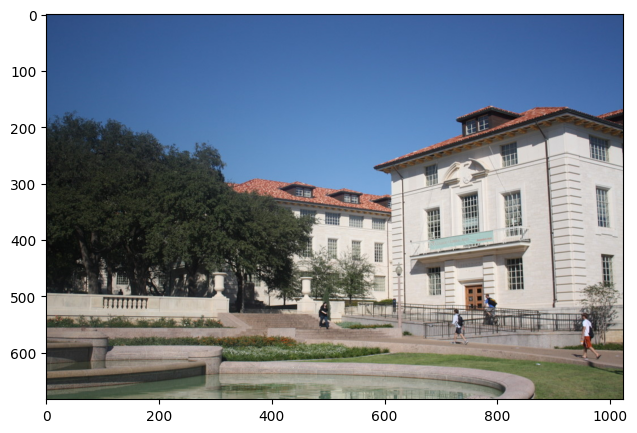

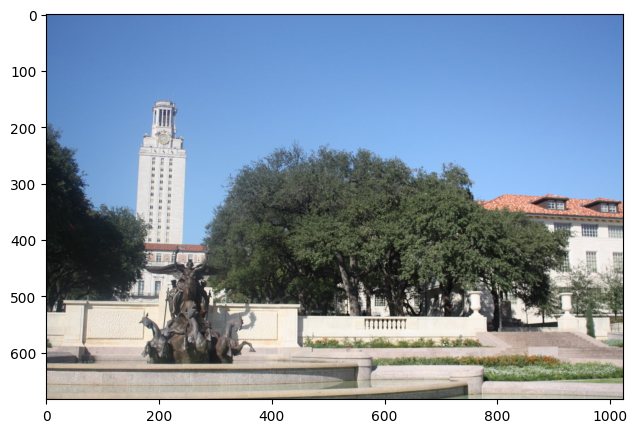

In [ ]:
img1= cv2.imread(r"D:\MERNA\CV_assignments\assignment_2_materials\pano_image1.jpg")
img2= cv2.imread(r"D:\MERNA\CV_assignments\assignment_2_materials\pano_image2.jpg")

plt.figure(figsize=(10, 5))

plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

Sift detector and descriptor 

Number of good matches: 1072


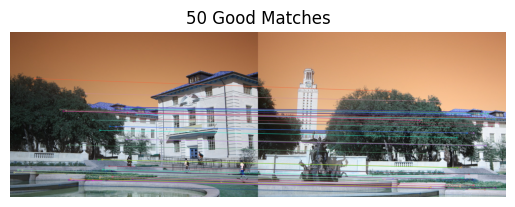

In [3]:
# SIFT detector
sift = cv2.SIFT_create()

img1_gray= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2_gray= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY) 
# keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(img1_gray, None)
kp2, des2 = sift.detectAndCompute(img2_gray, None)

# Match descriptors with BFMatcher and KNN
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
print(f"Number of good matches: {len(good_matches)}")    
# PICK 50 random matches
good_matches = sorted(good_matches,key=lambda x: x.distance)[:50]  

# Draw the matches  
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches)
plt.axis('off')           
plt.title("50 Good Matches")
plt.show()

Computing Homography Ah=0 using direct DLT (without ransac) 

In [4]:
def find_Homography(src_pts, dst_pts):
    Ar = []
    for (x, y), (xp, yp) in zip(src_pts, dst_pts):
        Ar.append([-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
        Ar.append([0, 0, 0, -x, -y, -1, x*yp, y*yp, yp])
    Ar = np.array(Ar)

    # Solve Ah = 0 using SVD
    U, S, Vt = np.linalg.svd(Ar)
    H = Vt[-1].reshape(3, 3) # The homography is the last column of Vt
    H= H / H[2, 2] # Normalize the homography matrix (Homogenous)
    
    return H


Ransac for inliers 

In [5]:
# function to get inliers and outliers
def ransac_homography(kp1, kp2, matches, threshold=5.0, iterations=1000):
    best_inliers = []
    best_H = None

    all_src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    all_dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 2)
    for _ in range(iterations):
        # Randomly select 4 matches
        sample_matches = np.random.choice(np.array(matches), 4, replace=False)
        src_pts = np.float32([kp1[m.queryIdx].pt for m in sample_matches])
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in sample_matches])

        # Compute homography
        H = find_Homography(src_pts, dst_pts)

        # Project points from image 1 to image 2 using the homography
        projected_pts = cv2.perspectiveTransform(all_src_pts, H).reshape(-1, 2)

        # Calculate distances between projected points and actual points in image 2
        distances = np.linalg.norm(projected_pts - all_dst_pts, axis=1)

        # Find inliers based on the distance threshold
        inliers = np.where(distances < threshold)[0]
        # Update the best homography if we found more inliers
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H
    if best_H is not None and len(best_inliers) > 4:
        print(f"Number of inliers: {len(best_inliers)}")
        # Recompute homography using all inliers
        inlier_matches = [matches[i] for i in best_inliers]
        inlier_src_pts = np.float32([kp1[m.queryIdx].pt for m in inlier_matches])
        inlier_dst_pts = np.float32([kp2[m.trainIdx].pt for m in inlier_matches])
        best_H = find_Homography(inlier_src_pts, inlier_dst_pts)
    return best_H, best_inliers

Computing homography with Ransac

In [6]:
# compute homography using RANSAC
H, inliers = ransac_homography(kp1, kp2, good_matches)  
print('homography matrix:')
print(H)

Number of inliers: 50
homography matrix:
[[ 7.57133444e-01  3.98552844e-02  4.47111179e+02]
 [-1.38406792e-01  9.10754146e-01  7.67278948e+01]
 [-2.17984894e-04 -3.10759178e-05  1.00000000e+00]]


Forward and Inverse Warping 

In [7]:
def forward_warp(image, H, output_shape, return_mask=False):
    h, w = output_shape
    warped_image = np.zeros((h, w, 3), dtype=np.float32)
    weight_map = np.zeros((h, w), dtype=np.float32)
    mask = np.zeros((h, w), dtype=bool)

    # Split into channels and warp separately
    for c in range(3):
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                src_point = np.array([x, y, 1])
                dst_point = H @ src_point
                dst_x, dst_y = (dst_point[:2] / dst_point[2]).astype(int)
                if 0 <= dst_x < w and 0 <= dst_y < h:
                    warped_image[dst_y, dst_x, c] += image[y, x, c]
                    weight_map[dst_y, dst_x] += 1
                    mask[dst_y, dst_x] = True

    # Normalize
    for y in range(h):
        for x in range(w):
            if weight_map[y, x] > 0:
                warped_image[y, x] /= weight_map[y, x]

    warped_image = np.clip(warped_image, 0, 255).astype(np.uint8)
    return (warped_image, mask) if return_mask else warped_image




# Map destination image to source image using the homography
def inverse_warp(image, H, output_shape):
    h, w = output_shape
    warped_image = np.zeros((h, w, 3), dtype=np.uint8)
    H_inv = np.linalg.inv(H)

    # Split the source image into 3 channels (R, G, B)
    channels = [image[:, :, i] for i in range(3)]

    # For each channel (R, G, B), apply inverse warping separately
    for c in range(3):
        channel = channels[c]  # Select the R, G, or B channel
        for y in range(h):
            for x in range(w):
                dst_point = np.array([x, y, 1])
                src_point = H_inv @ dst_point
                src_x, src_y = src_point[:2] / src_point[2]

                if 0 <= src_x < image.shape[1] - 1 and 0 <= src_y < image.shape[0] - 1:
                    x0, y0 = int(src_x), int(src_y)
                    dx, dy = src_x - x0, src_y - y0

                    # Linear interpolation for the current channel (R, G, or B)
                    warped_image[y, x, c] = (
                        (1 - dx) * (1 - dy) * channel[y0, x0] +
                        dx * (1 - dy) * channel[y0, x0 + 1] +
                        (1 - dx) * dy * channel[y0 + 1, x0] +
                        dx * dy * channel[y0 + 1, x0 + 1]
                    )

    return warped_image

def combined_warp(image, H, output_shape):
    # Forward warp
    forward_result, forward_mask = forward_warp(image, H, output_shape, return_mask=True)

    # Inverse warp
    inverse_result = inverse_warp(image, H, output_shape)

    # Combine
    h, w = output_shape
    final_result = np.zeros((h, w, 3), dtype=np.uint8)

    for y in range(h):
        for x in range(w):
            if forward_mask[y, x]:
                final_result[y, x] = forward_result[y, x]
            else:
                final_result[y, x] = inverse_result[y, x]

    return final_result




Compute the bounding box for the final mosaic image 
 
 It determines the output image's dimensions and how much to offset each image to fit them properly together.

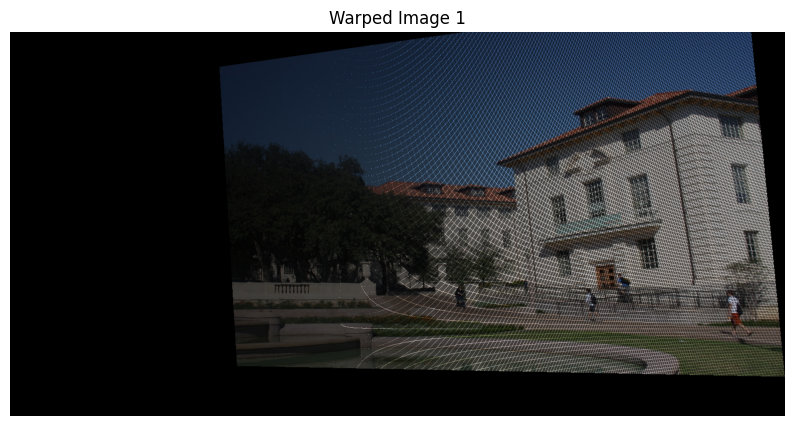

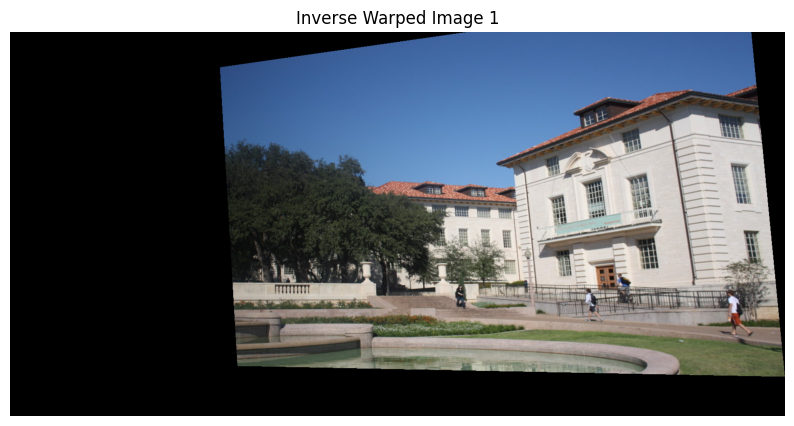

In [ ]:
def compute_output_shape_with_offsets(image1, image2, H):
    h1, w1 = image1.shape[:2] # image to be warped
    h2, w2 = image2.shape[:2] # reference image

    # Corners
    corners1 = np.array([[0, 0], [w1, 0], [w1, h1], [0, h1]], dtype=np.float32).reshape(-1, 1, 2)
    corners1_warped = cv2.perspectiveTransform(corners1, H) # Warp corners of image1 to image2

    corners2 = np.array([[0, 0], [w2, 0], [w2, h2], [0, h2]], dtype=np.float32).reshape(-1, 1, 2)

    # Combine all corners to determine the bounding box
    all_corners = np.vstack((corners1_warped, corners2))
    x_min = int(all_corners[:, 0, 0].min())
    x_max = int(all_corners[:, 0, 0].max())
    y_min = int(all_corners[:, 0, 1].min())
    y_max = int(all_corners[:, 0, 1].max())

    # Compute output dimensions and offsets
    output_width = x_max - x_min
    output_height = y_max - y_min
    # Offsets to shift the warped image to the correct position ensuring coordinates are shifted so all pixels of  warped image fit into the output image.
    x_offset = -x_min
    y_offset = -y_min

    return output_height, output_width, x_offset, y_offset


# Compute output shape and offsets
output_height, output_width, x_offset, y_offset = compute_output_shape_with_offsets(img1, img2, H)
output_shape = (output_height, output_width)

# Perform warping
warped_img1 = combined_warp(img1, H, output_shape)
# Perform inverse warping 
warped_img1_inv = inverse_warp(img1, H, output_shape)

# Plot the result
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(warped_img1, cv2.COLOR_BGR2RGB))
plt.title("Warped Image 1")
plt.axis("off")
plt.show()
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(warped_img1_inv, cv2.COLOR_BGR2RGB))
plt.title("Inverse Warped Image 1")
plt.axis("off")
plt.show()

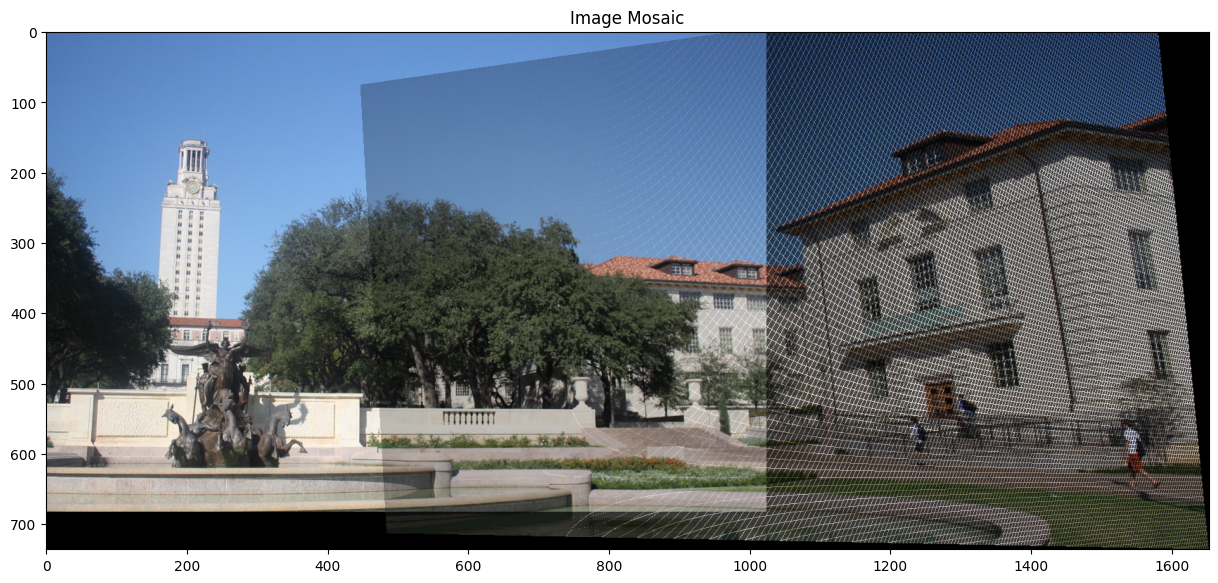

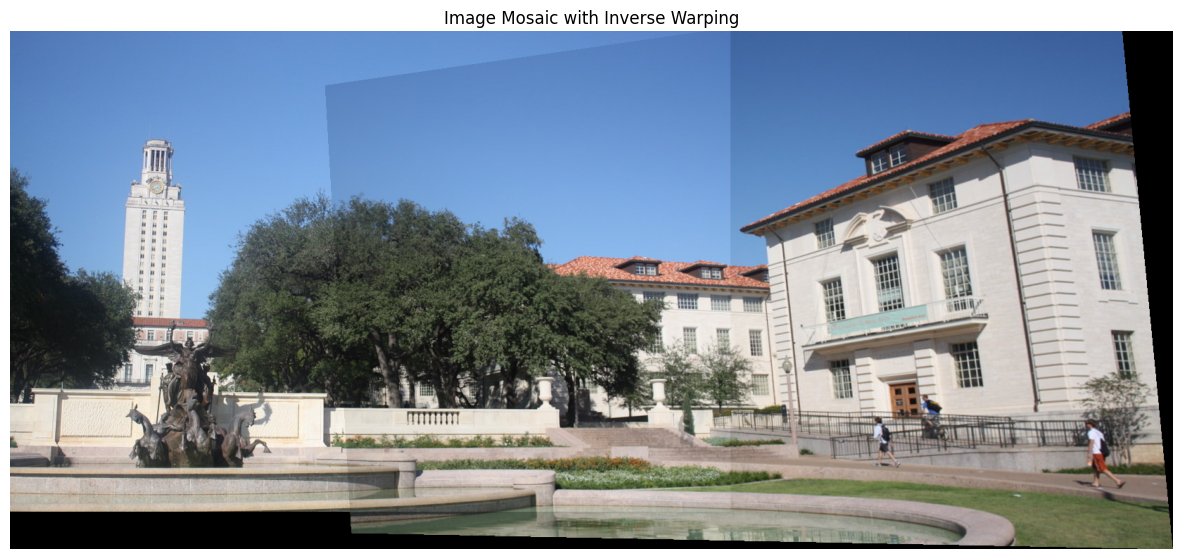

In [9]:
def create_mosaic(warped_image, base_image, x_offset, y_offset):
    h, w, _ = warped_image.shape
    mosaic = np.zeros((h, w, 3), dtype=np.uint8)

    # Paste base image
    mosaic[y_offset:y_offset + base_image.shape[0], x_offset:x_offset + base_image.shape[1]] = base_image


    for y in range(h):
        for x in range(w):
            if np.any(warped_image[y, x] > 0):  # Non-black pixel
                if np.any(mosaic[y, x] > 0):  # Blending where overlap exists
                    mosaic[y, x] = (0.7 * mosaic[y, x] + 0.3 * warped_image[y, x]).astype(np.uint8)

                else:
                    mosaic[y, x] = warped_image[y, x]
    gray_mosaic = cv2.cvtColor(mosaic, cv2.COLOR_BGR2GRAY)
    coords = cv2.findNonZero(gray_mosaic)
    x, y, w, h = cv2.boundingRect(coords)
    padding = 20  # Adjust as needed
    cropped_mosaic = mosaic[max(0, y-padding):y+h+padding, max(0, x-padding):x+w+padding]

    cropped_mosaic = mosaic[y:y + h, x:x + w]
    return cropped_mosaic

mosaic = create_mosaic(warped_img1, img2,0,0)
mosaic2 = create_mosaic(warped_img1_inv, img2,0,0)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))
plt.title("Image Mosaic")

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(mosaic2, cv2.COLOR_BGR2RGB))
plt.title("Image Mosaic with Inverse Warping")
plt.axis("off")
plt.show()

BONUS PART

Number of good matches between image 3 and 4: 320


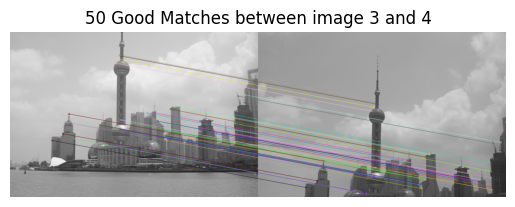

Number of inliers: 47
homography matrix between image 3 and 4:
[[ 9.68416111e-01 -4.55962356e-02  4.29337526e+01]
 [-2.30393570e-03  9.37199419e-01  2.00766956e+02]
 [-1.12410157e-05 -7.63653752e-05  1.00000000e+00]]


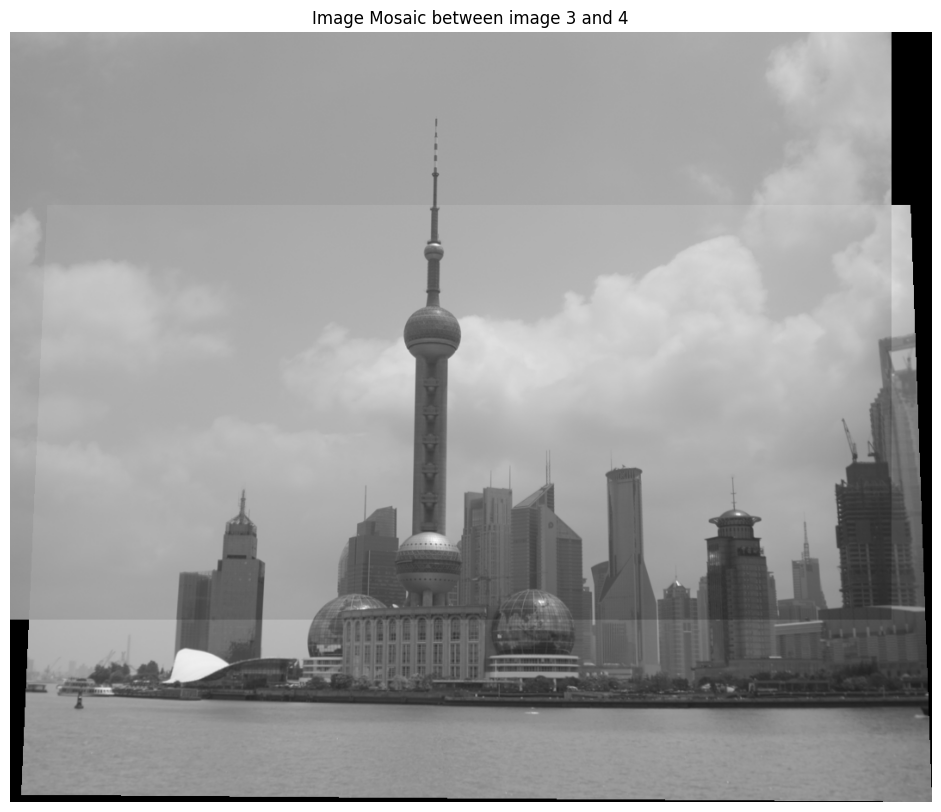

In [ ]:
img3=cv2.imread(r"D:\MERNA\CV_assignments\assignment_2_materials\shanghai-21.png")
img4=cv2.imread(r"D:\MERNA\CV_assignments\assignment_2_materials\shanghai-22.png")
img5=cv2.imread(r"D:\MERNA\CV_assignments\assignment_2_materials\shanghai-23.png")

# SIFT detector

img3_gray= cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)   
img4_gray= cv2.cvtColor(img4,cv2.COLOR_BGR2GRAY)
img5_gray= cv2.cvtColor(img5,cv2.COLOR_BGR2GRAY)
# keypoints and compute descriptors
kp3, des3 = sift.detectAndCompute(img3_gray, None)
kp4, des4 = sift.detectAndCompute(img4_gray, None)
kp5, des5 = sift.detectAndCompute(img5_gray, None)
# Match descriptors with BFMatcher and KNN for image 3 and 4
matches34 = bf.knnMatch(des3, des4, k=2)
# Apply Lowe's ratio test
good_matches34 = []
for m, n in matches34:
    if m.distance < 0.75 * n.distance:
        good_matches34.append(m)
print(f"Number of good matches between image 3 and 4: {len(good_matches34)}")
# PICK 50 random matches    
good_matches34 = sorted(good_matches34,key=lambda x: x.distance)[:50]
# Draw the matches
img_matches3 = cv2.drawMatches(img3, kp3, img4, kp4, good_matches34, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches3)
plt.axis('off')
plt.title("50 Good Matches between image 3 and 4")
plt.show()
# compute homography using RANSAC for image 3 and 4
H34, inliers3 = ransac_homography(kp3, kp4, good_matches34)
print('homography matrix between image 3 and 4:')
print(H34)
# compute output shape and offsets for image 3 and 4
output_height34, output_width34, x_offset34, y_offset34 = compute_output_shape_with_offsets(img3, img4, H34)
output_shape34 = (output_height34, output_width34)
# Perform inverse warping for image 3 and 4
warped_img3_inv = inverse_warp(img3, H34, output_shape34)
# Create mosaic for image 3 and 4
img34 = create_mosaic(warped_img3_inv, img4, x_offset34, y_offset34)
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img34, cv2.COLOR_BGR2RGB))
plt.title("Image Mosaic between image 3 and 4")
plt.axis("off")
plt.show()



Stitching output with 3rd image

Number of good matches : 396


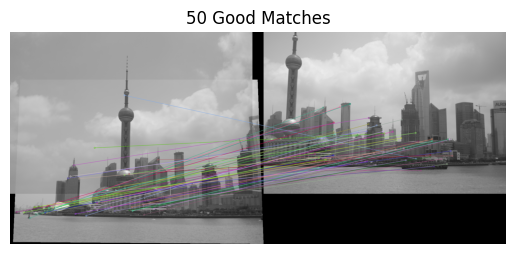

Number of inliers: 50
homography matrix between image 34 and 5:
[[ 8.65567243e-01 -9.95545866e-03  3.70556815e+02]
 [-9.63190865e-02  9.03909706e-01  2.38740130e+02]
 [-1.15396745e-04 -7.40761665e-05  1.00000000e+00]]


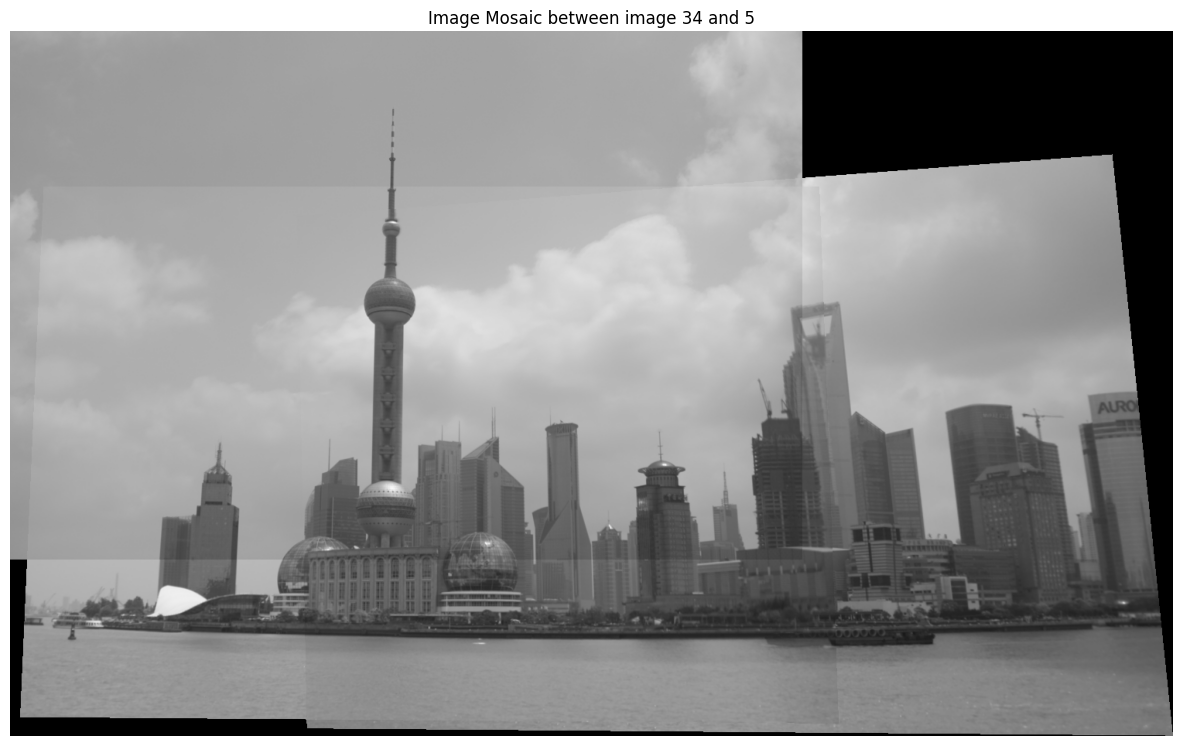

In [ ]:
# Stitching output image 3 and 4 with image 5
# keypoints and compute descriptors for the mosaic34
kp_mosaic34, des_mosaic34 = sift.detectAndCompute(img34, None)
# Match descriptors with BFMatcher and KNN for mosaic34 and image 5
matches345 = bf.knnMatch( des5,des_mosaic34, k=2)
# Apply Lowe's ratio test
good_matches345 = []
for m, n in matches345:
    if m.distance < 0.75 * n.distance:
        good_matches345.append(m)
print(f"Number of good matches : {len(good_matches345)}")
# PICK 50 random matches
good_matches345 = sorted(good_matches345,key=lambda x: x.distance)[:50]
# Draw the matches
img_matches4 = cv2.drawMatches(img34, kp_mosaic34, img5, kp5, good_matches345, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches4)
plt.axis('off')
plt.title("50 Good Matches")
plt.show()
# compute homography using RANSAC for image 34 and 5
# image 34 is the reference image and image 5 is the image to be warped
H345, inliers4 = ransac_homography(kp5, kp_mosaic34, good_matches345)
print('homography matrix between image 34 and 5:')
print(H345)
# compute output shape and offsets for image 34 and 5
# img5 is the image to be warped and img34 is the reference image
output_height345, output_width345, x_offset345, y_offset345 = compute_output_shape_with_offsets(img5, img34, H345)
output_shape345 = (output_height345, output_width345)
# Perform inverse warping for image 5
warped_img5 = inverse_warp(img5, H345, output_shape345)
# Create mosaic for image 34 and 5
mosaic345 = create_mosaic(warped_img5, img34 , x_offset345, y_offset345)
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(mosaic345, cv2.COLOR_BGR2RGB))
plt.title("Image Mosaic between image 34 and 5")
plt.axis("off")
plt.show()